## Import Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100)

import matplotlib.pyplot as plt
import pandas_datareader as wb
import datetime as dt
import numpy as np

## Set Parameters

In [2]:
ticker = 'SPY'
start = '2000-01-01'
end = None

# rsi parameters
rsi_window = 9
oversold = 30
overbought = 80

# bb parameters
bb_window = 40
bb_stdev = 2

# macd params
fast_ema = 20
slow_ema = 40
sign_ema = 3
band = 0.03

## Retrieve Data & Engineer Features

In [3]:
# fetch daily data
data = wb.DataReader(ticker, 'yahoo', start, end)[['Open','High','Low','Close']]

# calculate daily return
data['Return'] = data['Close'].pct_change()

# calculate fast and slow ema
data[f'EMA_{fast_ema}'] = data['Close'].ewm(span=fast_ema).mean()
data[f'EMA_{slow_ema}'] = data['Close'].ewm(span=slow_ema).mean()
data['MACD_Diff'] = data[f'EMA_{fast_ema}'] - data[f'EMA_{slow_ema}']
data['Histogram'] = data['MACD_Diff'] - data['MACD_Diff'].ewm(span=sign_ema).mean()

# calculate ema trend
data['MACD_Signal'] = data['Histogram'].apply(lambda x: 1 if x >= band else -1 if x <= -band else np.nan)
data['MACD_Signal'].fillna(method='pad', inplace=True)

# get delta of close price every day
close_delta = data['Close'].diff()[1:]

# create a copy from close price delta for data manipulation
close_up, close_down = close_delta.copy(), close_delta.copy()

# zero out those days with down movements (including no movement) in close_up series
close_up[close_up <= 0] = 0

# zero out those days with up movements in close_down series
close_down[close_down > 0] = 0

# calculate ema of the ups and downs
smoothed_rsi_window = rsi_window * 2 - 1
roll_up_ewm = close_up.ewm(span=smoothed_rsi_window).mean()
roll_down_ewm = close_down.abs().ewm(span=smoothed_rsi_window).mean()

# calculate rsi
data['RSI'] = 100.00 - (100.00 / (1.00 + roll_up_ewm / roll_down_ewm))

# calculate bollinger band on rsi line
data['UBB'] = data['RSI'].rolling(bb_window).mean() + bb_stdev * data['RSI'].rolling(bb_window).apply(np.std)
data['LBB'] = data['RSI'].rolling(bb_window).mean() - bb_stdev * data['RSI'].rolling(bb_window).apply(np.std)

# compute the difference from either UBB or LBB
data['UBB_DIFF'] = data['UBB'] - data['RSI']
data['LBB_DIFF'] = data['RSI'] - data['LBB']
data['RSI_DIFF'] = data[['UBB_DIFF','LBB_DIFF']].min(axis=1)

# give remarks
data['Remarks'] = ''

# oversold & extreme oversold condition
data.loc[data['RSI'] < data['LBB'],'Remarks'] = 'Oversold'
data.loc[(data['RSI'] < data['LBB']) & (data['RSI'] < oversold),'Remarks'] = 'Extreme Oversold'

# overbought & extreme overbought condition
data.loc[data['RSI'] > data['UBB'],'Remarks'] = 'Overbought'
data.loc[(data['RSI'] > data['UBB']) & (data['RSI'] > overbought),'Remarks'] = 'Extreme Overbought'

# give signals
data['RSI_Signal'] = np.nan

for i in range(1,len(data)):
    
    # set variable for reference
    today = data.index[i]
    rmk_ytd = data.iloc[i-1]['Remarks']
    rsi_diff_now = data.iloc[i]['RSI_DIFF']
    
    # buy signal
    if (rmk_ytd == 'Oversold') and (rsi_diff_now > 0):
        data.loc[today,'Remarks'] = 'Buy'
        data.loc[today,'RSI_Signal'] = 1
        
    # sell signal
    elif (rmk_ytd == 'Overbought') and (rsi_diff_now > 0):
        data.loc[today,'Remarks'] = 'Sell'
        data.loc[today,'RSI_Signal'] = 0
        
    # extreme buy signal
    elif (rmk_ytd == 'Extreme Oversold') and (rsi_diff_now > 0):
        data.loc[today,'Remarks'] = 'Extreme Buy'
        data.loc[today,'RSI_Signal'] = 1

    # extreme sell signal
    elif (rmk_ytd == 'Extreme Overbought') and (rsi_diff_now > 0):
        data.loc[today,'Remarks'] = 'Extreme Sell'
        data.loc[today,'RSI_Signal'] = 0
    
    else: pass
    
# carry forward signal
data['RSI_Signal'] = data['RSI_Signal'].fillna(method='pad')

# drop NaN and burn the first 250 data points
data.dropna(inplace=True)
data = data.iloc[250:]

# combine and de-leverage signal
data['Signal'] = data['MACD_Signal'] + data['RSI_Signal']
data['Signal'] = data['Signal'].apply(lambda x: 1 if x > 1 else x)

## Visualize Signal

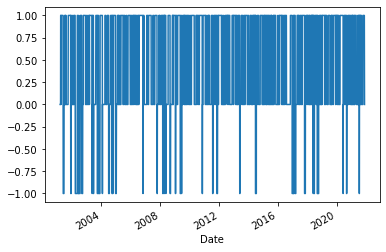

In [4]:
data.loc[:,'Signal'].plot(); plt.show()

> Practically, we can use Put options to hedge the position or Call options to leverage bullish bets.

## Functionalize Analytics

In [5]:
# define function to compute Sharpe ratio
def sharpe_ratio(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(252)

# define function to compute maximum drawdown
def max_drawdown(daily_return):
    rolling_max = (daily_return + 1).cumprod().expanding().max()
    monthly_drawdown = (daily_return + 1).cumprod() / rolling_max.values - 1.0
    max_drawdown = monthly_drawdown.abs().max() * 100
    return max_drawdown

# define function to compute annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

def calmar_ratio(daily_return):
    return annualized_return(daily_return) / max_drawdown(daily_return)

## Backtest Strategy

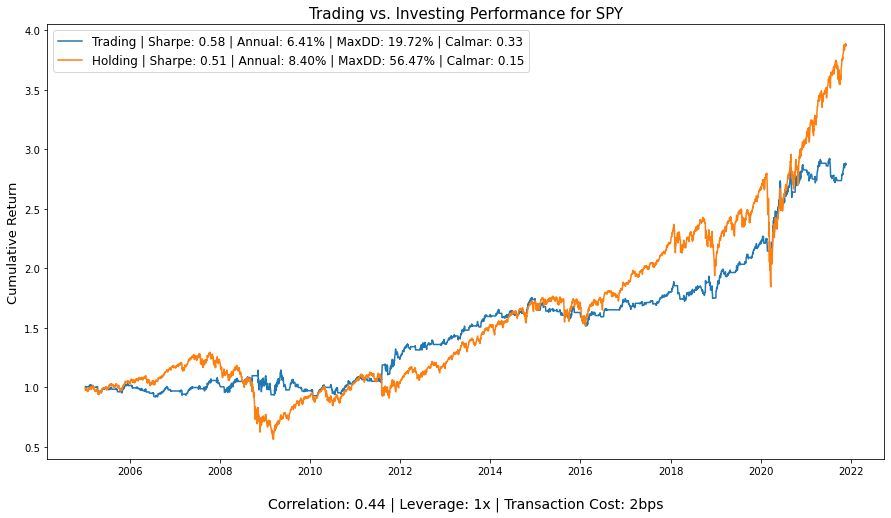

In [8]:
# set backtest parameters
start_year = '2005'
end_year = None
tc = 2 # in basis points
leverage = 1

# multiply 1-day lagged signal with daily return
trading = data.loc[start_year:end_year,'Signal'].shift(2) * data.loc[start_year:end_year,'Return'] * leverage
holding = data.loc[start_year:end_year,'Return']

# deduct transaction cost
cost = tc / 10000
turnover = data.loc[start_year:end_year,'Signal'].shift().diff().fillna(0).abs()
trading = trading - (turnover * cost)

# plot chart
plt.figure(figsize=(15,8))
plt.title(f"Trading vs. Investing Performance for {ticker}", fontsize=15)
plt.plot((trading + 1).cumprod(skipna=True),
         label=f"Trading | Sharpe: {sharpe_ratio(trading):.2f} | Annual: {annualized_return(trading):.2f}% | MaxDD: {max_drawdown(trading):.2f}% | Calmar: {calmar_ratio(trading):.2f}")
plt.plot((holding + 1).cumprod(skipna=True),
         label=f"Holding | Sharpe: {sharpe_ratio(holding):.2f} | Annual: {annualized_return(holding):.2f}% | MaxDD: {max_drawdown(holding):.2f}% | Calmar: {calmar_ratio(holding):.2f}")
plt.ylabel('Cumulative Return', fontsize=13)
plt.xlabel(f"\nCorrelation: {trading.corr(holding):.2f} | Leverage: {leverage}x | Transaction Cost: {tc}bps", fontsize=14)
plt.legend(loc=2, fontsize=12)
plt.show()

# save daily return
trading.to_csv('index_timing_return.csv')

In [7]:
data[['MACD_Signal','RSI_Signal','Signal']].tail(20)

,MACD_Signal,RSI_Signal,Signal
Date,,,
2021-10-28,1.000,1.000,1.000
2021-10-29,1.000,1.000,1.000
2021-11-01,1.000,1.000,1.000
2021-11-02,1.000,1.000,1.000
2021-11-03,1.000,1.000,1.000
2021-11-04,1.000,1.000,1.000
2021-11-05,1.000,1.000,1.000
2021-11-08,1.000,1.000,1.000
2021-11-09,1.000,1.000,1.000


## The End